# Overview

This overview demonstrates the basic capabilities of `eodag` in a simple worflow, whose steps are introduced in more details in the following pages.

The workflow consists of the following steps:

1. [Configure](#Configure): `eodag` is configured to use the provider *PEPS* (registering to *PEPS* is required to download the products, see [how to register to a provider](../../getting_started_guide/register.rst))
2. [Search](#Search): *Sentinel 2 Level-1C* products (i.e. images) are searched for over an area in France in March 2021.
3. [Crunch](#Crunch): Two dedicated filters - that we call *crunchers* - provided by `eodag`  are used to select products with a cloud cover less than 30% and covering the city of Toulouse (France).
4. [Serialize](#Serialize): Save the filtered products as a GeoJSON file.
4. [Download](#Download): The products are downloaded.
5. [Post-process](#Post-process): [eodag-cube](https://github.com/CS-SI/eodag-cube) is an external package that is used to access a product's data, it is going to be used to calculate the NDVI of a product.

## Configure

Let us first create a workspace directory to save products downloaded during this workflow.

In [1]:
import os

workspace = 'eodag_workspace_overview'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

Now we will configure `eodag` to be able to download using *PEPS*. For that we need to fill our credentials:

* in the user configuration file `~/.config/eodag.eodag.yml`:

```yaml
peps:
    priority: # Lower value means lower priority (Default: 1)
    search:  # Search parameters configuration
    download:
        extract:  # whether to extract the downloaded products (true or false, Default: true).
        outputs_prefix: # where to store downloaded products.
        dl_url_params:  # additional parameters to pass over to the download url as an url parameter
        delete_archive: # whether to delete the downloaded archives (true or false, Default: true).
    auth:
        credentials:
            username: PLEASE_CHANGE_ME
            password: PLEASE_CHANGE_ME
```

* or using environment variables: (we also set `outputs_prefix`, the directory where to store downloaded products)

In [2]:
# os.environ["EODAG__PEPS__AUTH__CREDENTIALS__USERNAME"] = "PLEASE_CHANGE_ME"
# os.environ["EODAG__PEPS__AUTH__CREDENTIALS__PASSWORD"] = "PLEASE_CHANGE_ME"
os.environ["EODAG__PEPS__DOWNLOAD__OUTPUTS_PREFIX"] = os.path.abspath(workspace)

Logging is then activated with the [setup_logging()](../../api_reference/utils.rst#eodag.utils.logging.setup_logging) method. It's a useful way to see what `eodag` does under the hood, e.g. requesting the provider, adapting the response. It's also useful to detect when things go wrong, and, if relevant, create an [issue on GitHub](https://github.com/CS-SI/eodag/issues) with the log messages.

In [3]:
from eodag import setup_logging
setup_logging(2)  # 3 for even more information

The next object to import, and this is certainly one of the most important objects provided by `eodag`, is the [EODataAccessGateway](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway) class. The creation of a single instance of this class is enough in a workflow, it is going to take care of configuring the providers, exposing the products configured off-the-shelf by `eodag`, and many more things.

In [4]:
from eodag import EODataAccessGateway
dag = EODataAccessGateway()

2023-10-17 16:51:54,405 eodag.config                     [INFO    ] Loading user configuration from: /home/anesson/.config/eodag/eodag.yml
2023-10-17 16:51:54,592 eodag.core                       [INFO    ] Locations configuration loaded from /home/anesson/.config/eodag/locations.yml


`eodag` stores an internal catalog of products it makes easily accessible. *Sentinel 2 Level-1C* products are designated with the identifier *S2_MSI_L1C*. It's possible to check that it's made available by *PEPS* with the method [list_product_types()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.list_product_types) which returns a list of dictionnaries, each one of them containing general metadata (`eodag`'s product type ID, platform, sensor type, etc.).

In [5]:
[product_type["ID"] for product_type in dag.list_product_types("peps")]

['S1_SAR_GRD', 'S1_SAR_OCN', 'S1_SAR_SLC', 'S2_MSI_L1C', 'S2_MSI_L2A']

The method [available_providers()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.available_providers) allows to get the list of providers that make available a given product.

In [6]:
dag.available_providers("S2_MSI_L1C")

['astraea_eod',
 'aws_eos',
 'cop_dataspace',
 'creodias',
 'earth_search',
 'earth_search_gcs',
 'onda',
 'peps',
 'sara',
 'usgs',
 'wekeo']

Finally *PEPS* is declared as the preferred provider, which means that `eodag` will look for products with this provider (all the providers are pre-configured).

In [7]:
dag.set_preferred_provider("peps")

## Search

The [EODataAccessGateway](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway) class provides three search methods which have a similar signature but behave in different ways:

[search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) returns a tuple with:

* a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) that stores the products obtained from a given **page** (default: `page=1`) and a given maximum **number of items per page** (default: `items_per_page=20`)
* an integer that is the **estimated** total number of products matching the search criteria

<div class="alert alert-info">

Note

[search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) returns a *paginated result*. Pagination is the act of serving the result of a search page by page, each page contaning a maximum number of items. This is ubiquitous among search engines, e.g. a Google search displays in the browser 10 results per page. Pagination is built deep into the implementation of `eodag` since most providers return a paginated result.

</div>

<div class="alert alert-info">

Note

A search made with the [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) method with its default parameter often ends up with a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) containing 20 products and a significantly greater estimated total number of products available. The parameter `items_per_page` can be set to a higher value, or, the [search_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_all) method can be used instead.

</div>

<div class="alert alert-warning">

Warning

The second element returned by [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) is the **estimated** total number of products matching the search criteria, since, unfortunately, all the providers do not return the **exact** total number.

</div>

[search_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_all) returns a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) that contains **all** the products matching the search criteria. It takes the pain away from thinking about pagination.

[search_iter_page()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_iter_page) is a generator that returns a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) page per page.

To get the *S2_MSI_L1C* products looked for, [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) is used first as it's handy to obtain some products and inspect them. Then [search_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_all) is used to make all the products offered by *PEPS* are collected.

In [8]:
search_criteria = {
    "productType": "S2_MSI_L1C",
    "start": "2021-03-01",
    "end": "2021-03-31",
    "geom": {"lonmin": 1, "latmin": 43, "lonmax": 2, "latmax": 44}
}

The search criteria in this example consists of:

* `productType`: `eodag`'s product type
* `start` and `end`: the start and end sensing datetimes (UTC)
* `geom`: the region of interest, which can be defined in different ways (`list`, `dict`, WKT string, `shapely.geometry`).

In [9]:
products_first_page, estimated_total_number = dag.search(**search_criteria)

2023-10-17 16:51:55,786 eodag.core                       [INFO    ] Searching product type 'S2_MSI_L1C' on provider: peps
2023-10-17 16:51:55,788 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2023-10-17 16:51:56,737 eodag.core                       [INFO    ] Found 68 result(s) on provider 'peps'


In [10]:
print(f"Got {len(products_first_page)} products and an estimated total number of {estimated_total_number} products.")

Got 20 products and an estimated total number of 68 products.


A [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) contains a number of [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct). Each one of them has a `properties` attribute that is a dictionnary storing the product's metadata.

In [11]:
products_first_page

SearchResult([EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834, provider=peps),
              EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TCJ_20230602T033834, provider=peps),
              EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDJ_20230602T033834, provider=peps),
              EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TCH_20230602T033834, provider=peps),
              EOProduct(id=S2A_MSIL1C_20210326T105031_N0500_R051_T31TCJ_20230515T023730, provider=peps),
              EOProduct(id=S2A_MSIL1C_20210326T105031_N0500_R051_T31TDH_20230515T023730, provider=peps),
              EOProduct(id=S2A_MSIL1C_20210326T105031_N0500_R051_T31TDJ_20230515T023730, provider=peps),
              EOProduct(id=S2A_MSIL1C_20210326T105031_N0500_R051_T31TCH_20230515T023730, provider=peps),
              EOProduct(id=S2A_MSIL1C_20210323T104021_N0500_R008_T31TCH_20230523T094723, provider=peps),
              EOProduct(id=S2A_MSIL1C_20210323T104021_N

In [12]:
one_product = products_first_page[0]
one_product.properties.keys()

dict_keys(['abstract', 'instrument', 'platform', 'platformSerialIdentifier', 'processingLevel', 'keywords', 'sensorType', 'license', 'missionStartDate', 'title', 'productType', 'uid', 'keyword', 'resolution', 'organisationName', 'publicationDate', 'parentIdentifier', 'orbitNumber', 'orbitDirection', 'cloudCover', 'snowCover', 'creationDate', 'modificationDate', 'sensorMode', 'startTimeFromAscendingNode', 'completionTimeFromAscendingNode', 'id', 'quicklook', 'downloadLink', 'tileIdentifier', 'storageStatus', 'thumbnail', 'resourceSize', 'resourceChecksum', 'visible', 'newVersion', 'isNrt', 'realtime', 'relativeOrbitNumber', 'useDatalake', 'bucket', 'prefix', 's2TakeId', 'bareSoil', 'highProbaClouds', 'mediumProbaClouds', 'lowProbaClouds', 'snowIce', 'vegetation', 'water', 'isRefined', 'nrtResource', 'services', 'links', 'storage'])

A product also has a `location` attribute. After being searched, it is equal to the *remote location* of the product, that will be used later by `eodag` to download it.

In [13]:
one_product.location

'https://peps.cnes.fr/resto/collections/S2ST/2d85d4c8-34c1-55dc-b43c-0ab0fe4c2b97/download'

All the products are now obtained from *PEPS*.

In [14]:
all_products = dag.search_all(**search_criteria)

2023-10-17 16:51:57,436 eodag.core                       [INFO    ] Searching product type 'S2_MSI_L1C' on provider: peps
2023-10-17 16:51:57,438 eodag.core                       [INFO    ] Iterate search over multiple pages: page #1
2023-10-17 16:51:57,440 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=500&page=1
2023-10-17 16:51:58,327 eodag.core                       [INFO    ] Found 68 result(s) on provider 'peps'


In [15]:
print(f"Got a total number of {len(all_products)} products.")

Got a total number of 68 products.


## Crunch

Crunching as defined in `eodag` is a way to filter the products contained in a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) object. Several crunchers/filters are available (e.g. [FilterProperty](../../plugins_reference/generated/eodag.plugins.crunch.filter_property.FilterProperty.rst#eodag.plugins.crunch.filter_property.FilterProperty) to filter products products according to one of their properties). They can be called by passing the cruncher object to [SearchResult.crunch()](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult.crunch) or by running a dedicated method (e.g. [SearchResult.filter_property()](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult.filter_property)).
The following example shows how to filter products to keep only those whose cloud cover is less than 30%.

In [16]:
filtered_products = all_products.filter_property(cloudCover=30, operator="lt")

2023-10-17 16:51:58,539 eodag.crunch.property            [INFO    ] Finished filtering products. 27 resulting products


In [17]:
print(f"Got now {len(filtered_products)} products after filtering by cloud coverage.")

Got now 27 products after filtering by cloud coverage.


Now, we use another cruncher to filter products containing a given geometry (Toulouse, France). We will use these products in [Post-process](#Post-process).

In [18]:
filtered_products = filtered_products.filter_overlap(geometry=(1.435905, 43.586857, 1.458907, 43.603827), contains=True)

2023-10-17 16:51:58,940 eodag.crunch.overlap             [INFO    ] Finished filtering products. 3 resulting products


In [19]:
print(f"Got now {len(filtered_products)} products after filtering by geometry.")

Got now 3 products after filtering by geometry.


## Serialize

The method [serialize()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.serialize) allows to save a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) as a *GeoJSON* file.

In [20]:
filtered_prods_filepath = dag.serialize(filtered_products, filename=os.path.join(workspace, "filtered_products.geojson"))

This method can come in handy to save the state of a search and restore it later with [deserialize_and_register()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.deserialize_and_register).

In [21]:
restored_filtered_prods = dag.deserialize_and_register(filtered_prods_filepath)

## Download

Before downloading any product, it can be useful to have a quick look at them. EO products usually offer a *quicklook* image, a low resolution by-product of the original data. An `EOProduct` has a [get_quicklook](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct.get_quicklook) method that takes care of downloading the quicklook image and returns its path. `matplotlib` can be used here to display the images collected.

0.00B [00:00, ?B/s]

2023-10-17 16:52:00,327 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_overview/quicklooks/S2B_MSIL1C_20210321T104639_N0209_R051_T31TCJ_20210321T130616


0.00B [00:00, ?B/s]

2023-10-17 16:52:00,791 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_overview/quicklooks/S2B_MSIL1C_20210321T104639_N0500_R051_T31TCJ_20230526T002554


0.00B [00:00, ?B/s]

2023-10-17 16:52:01,129 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_overview/quicklooks/S2B_MSIL1C_20210301T104859_N0500_R051_T31TCJ_20230604T191601


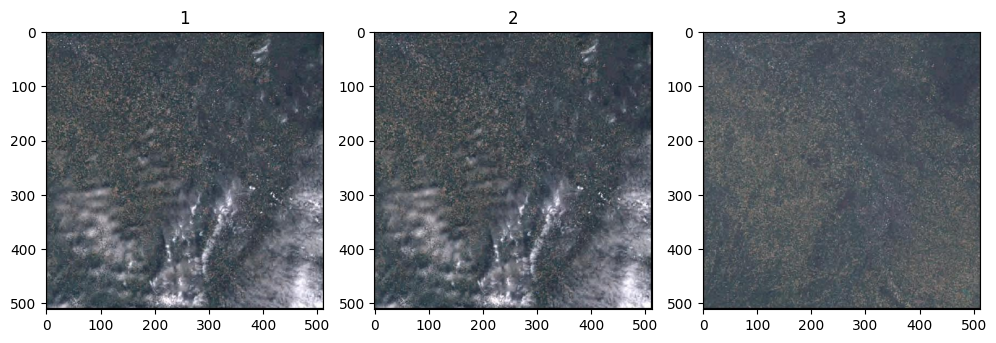

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

quicklooks_dir = os.path.join(workspace, "quicklooks")
if not os.path.isdir(quicklooks_dir):
    os.mkdir(quicklooks_dir)

fig = plt.figure(figsize=(10, 8))
for i, product in enumerate(filtered_products, start=1):

    # This line takes care of downloading the quicklook
    quicklook_path = product.get_quicklook(base_dir=quicklooks_dir)
    
    img = mpimg.imread(quicklook_path)
    ax = fig.add_subplot(1, 3, i)
    ax.set_title(i)
    plt.imshow(img)
plt.tight_layout()

[EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct)s can either be downloaded individually with [download()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.download) or together with [download_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.download_all) from a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult). The last image is going to be downloaded, it is cloud-free and has no no-data pixel.

In [23]:
product_to_download = filtered_products[-1]
product_path = dag.download(product_to_download)
product_path

0.00B [00:00, ?B/s]

2023-10-17 16:52:02,381 eodag.download.base              [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2ST/569f40e6-b634-5a63-ad5b-7ddc242a39dc/download


2023-10-17 16:59:38,005 eodag.download.base              [INFO    ] Extraction activated
2023-10-17 16:59:40,653 eodag.download.base              [INFO    ] Deleting archive S2B_MSIL1C_20210301T104859_N0500_R051_T31TCJ_20230604T191601.zip
2023-10-17 16:59:40,812 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/569f40e6-b634-5a63-ad5b-7ddc242a39dc/download


'/home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_overview/S2B_MSIL1C_20210301T104859_N0500_R051_T31TCJ_20230604T191601'

The `location` property of this product now points to a local path.

In [24]:
product_to_download.location

'file:///home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_overview/S2B_MSIL1C_20210301T104859_N0500_R051_T31TCJ_20230604T191601'

## Post-process

Now the product is downloaded, it can be post-processed with softwares such as [Sen2Cor](http://step.esa.int/main/snap-supported-plugins/sen2cor/) or [SNAP](http://step.esa.int/main/download/snap-download/).

At some point `eodag` had some capabilities to directly post-process a product, i.e. to access its data. These capabilities, which relied on [rasterio](https://rasterio.readthedocs.io/en/latest/), have been ported to the Python package [eodag-cube](https://github.com/CS-SI/eodag-cube) to avoid the heavy dependencies associated with  *GDAL* in particular. Installing this package is enough to benefit from its capabilities, it is going to extend [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) with a `get_data()` method which returns a product's image band as a `xarray.DataArray`.

The capabilities of [eodag-cube](https://github.com/CS-SI/eodag-cube) are used hereafter to compute the NDVI of the downloaded product over a sub-extent of the original product (this is actually Toulouse, France).

<div class="alert alert-warning">

Warning

[eodag-cube](https://github.com/CS-SI/eodag-cube) needs to be installed to run correcly the following code.

</div>

In [25]:
import warnings
import rasterio

# mute rasterio warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

crs = "epsg:4326"
resolution = 0.0001
sub_extent = (1.435905, 43.586857, 1.458907, 43.603827)
VIR = product_to_download.get_data(band="B04", extent=sub_extent, crs=crs, resolution=resolution)
NIR = product_to_download.get_data(band="B08", extent=sub_extent, crs=crs, resolution=resolution)
NDVI = (NIR - VIR * 1.) / (NIR + VIR)

The NDVI can quickly be plotted directly with `xarray` which uses `matplotlib` under the hood.

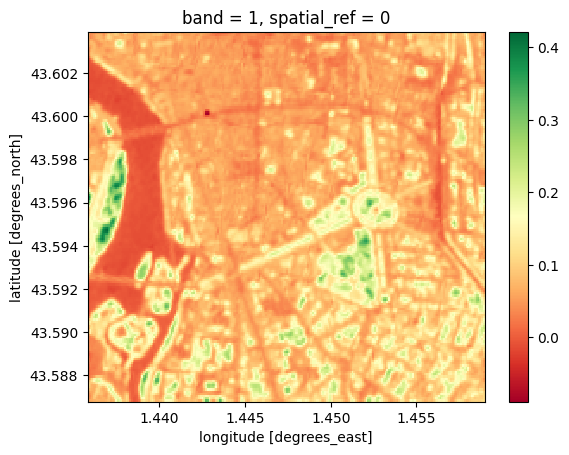

In [26]:
NDVI.plot(cmap="RdYlGn", center=False)